## Evaluation on Ground truth data

Ground truth modes
- Constant flow
- Mean flow + std
- Flow in non-overlapping regions

In [104]:
import os
import time as t
import numpy as np
import math


from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imageio import imread 

from PIL import Image

from utils import *
from numerics import *

In [66]:
def filter_and_summarize_velocities(amp, corr, peak, flow_x, flow_y):
    
    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    # 3. Mean velocity with filtering on velocities
    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth
    filtered_amp_seq = np.where(np.all([amp > min_vel_in_pixels, amp < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), amp, 0)


    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr * peak_ratio, 1, 0)

    # 5. Mean velocity with filtering on all constraints  
    filtered_all = vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak)
    
    del filtered_corr, filtered_amp_seq, filtered_peak
    
    return filtered_all 


# Settings

In [89]:
#gt_path = 'y:\\projects\\pn-reduction\\farago\\result\\watershed-gt-scan-dense-oy-300\\'
#res_path = 'y:\\projects\\pn-reduction\\ershov\\exp_div\\exp_div_par_300\\'

pixel_size = 4.0 # Simulation

bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering settings
min_corr_value = 0.2 

perc_filtering_threshold = 0.5
amp_mean_truth = 8

peak_ratio = 0.5

## Ground truth mode: Constant flow

In [113]:
res_path = '/mnt/LSDF/projects/pn-reduction/ershov/params_scan/params_scan_param_all_v2/'

gt_amp = 8

va = imread(res_path + 'params_scan_Tile_dall_amp_mean_filter_all.tif')
va_std = imread(res_path + 'params_scan_Tile_dall_amp_std_filter_all.tif')

va_mean = np.mean(va[90:90+65, 35:35+205])

diff_mean_amp = np.abs(gt_amp*vel_factor - va_mean)
std_amp = np.mean(va_std[90:90+65, 35:35+205])

print('GT velocity: ', gt_amp*vel_factor)
print('Result: ', va_mean)

print('Mean error:', diff_mean_amp)
print('Std:', std_amp)

('GT velocity: ', 181.81818181818184)
('Result: ', 181.40402)
('Mean error:', 0.41415960138496644)
('Std:', 5.255367)


## Ground truth mode: Non-overlapping clusters

In [131]:
datasets = ['250', '300', '400', '500', '600'][::-1]
#datasets = ['300']

amp_mean_list = []
amp_std_list = []
vx_mean_list = []
vx_std_list = []
vy_mean_list = []
vy_std_list = []

for dt in datasets:
    
    dataset = dt
    
    print('Dataset:', dataset)
    
    gt_path = '/mnt/LSDF/projects/pn-reduction/farago/result/watershed-gt-scan-dense-oy-' + dataset + '/'
    res_path = '/mnt/LSDF/projects/pn-reduction/ershov/exp_div/exp_div_par_' + dataset + '/'
    
    # Read ground truth flow
    gtx_orig = read_images_from_directory(gt_path, 'fo-'+dataset+'-gt-2')
    gty_orig = read_images_from_directory(gt_path, 'fo-'+dataset+'-gt-1')
    
    # Correct rotation and components to match coordinates
    gtx = - np.rot90(gty_orig, 3, axes=(1,2))
    gty = np.rot90(gtx_orig, 3, axes=(1,2))
    gta = np.sqrt(gtx**2 + gty**2)
    
    # Read computed autocorrelation results
    
    p = res_path + 'exp_div_Tile_d'+dataset
    
    if dataset=='250':
        max_images = 113
    else:
        max_images = 200
    
    vx = read_tiff(p +'_flow_x_seq.tif', max_images)
    vy = read_tiff(p +'_flow_y_seq.tif', max_images)
    va = np.sqrt(vx**2 + vy**2)
    
    corr = read_tiff(p + '_corr_seq.tif', max_images)
    peak = read_tiff(p + '_peak_seq.tif', max_images)
    
    # Filtered results (valid according to the filtering procedure)
    filtered = filter_and_summarize_velocities(va, corr, peak, vx, vy)
    
    # Consider indexes which are both valid in ground truth and filtered results
    ids = np.nonzero(gta*filtered)

    diff_mean_amp = np.mean(np.abs(gta[ids] - va[ids]))
    diff_std_amp = np.std(np.abs(gta[ids] - va[ids])) 
    
    diff_mean_vx = np.mean(np.abs(gtx[ids] - vx[ids]))
    diff_std_vx = np.std(np.abs(gtx[ids] - vx[ids])) 
    
    diff_mean_vy = np.mean(np.abs(gty[ids] - vy[ids]))
    diff_std_vy = np.std(np.abs(gty[ids] - vy[ids]))
    
    amp_mean_list.append(diff_mean_amp)
    amp_std_list.append(diff_std_amp)
    vx_mean_list.append(diff_mean_vx)
    vx_std_list.append(diff_std_vx)
    vy_mean_list.append(diff_mean_vy)
    vy_std_list.append(diff_std_vy)
    
      
    #print('Mean error:', diff_mean_amp * vel_factor)
    #print('Std of error:', diff_std_amp * vel_factor)
    

('Dataset:', '600')
('Dataset:', '500')
('Dataset:', '400')
('Dataset:', '300')
('Dataset:', '250')


In [132]:
datasets

['600', '500', '400', '300', '250']

### Plot results

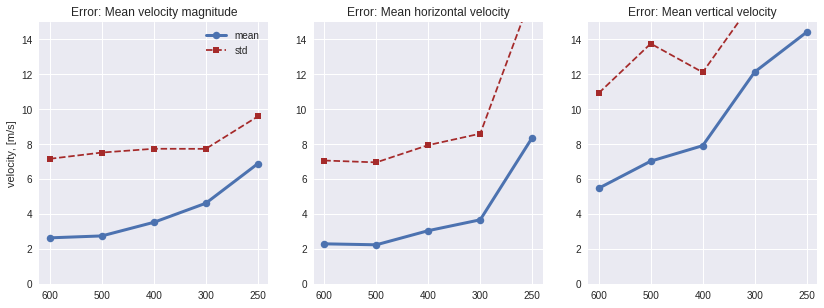

In [154]:
plt.style.use('seaborn')

fig = plt.figure(1)

ylim = (0, 20)  

fig.set_size_inches(12, 4, forward=True)
plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

gs = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(np.array(amp_mean_list)*vel_factor, linewidth=3, label='mean', marker='.', markersize=15)
ax1.plot(np.array(amp_std_list)*vel_factor, linestyle='--', color='brown', label ='std', marker='s', markersize=6)
ax1.set_title('Error: Mean velocity magnitude')
ax1.set_ylim((0,15))
ax1.set_ylabel('velocity, [m/s]')
ax1.set_xticks(range(5))
ax1.set_xticklabels(datasets)
ax1.legend()

ax2 = plt.subplot(gs[0,1])
ax2.plot(np.array(vx_mean_list)*vel_factor, linewidth=3, label='mean', marker='.', markersize=15)
ax2.plot(np.array(vx_std_list)*vel_factor, linestyle='--', color='brown', label ='std', marker='s', markersize=6)
ax2.set_title('Error: Mean horizontal velocity')
ax2.set_ylim((0,15))
ax2.set_xticks(range(5))
ax2.set_xticklabels(datasets)

ax3 = plt.subplot(gs[0,2])
ax3.plot(np.array(vy_mean_list)*vel_factor, linewidth=3, label='mean', marker='.', markersize=15)
ax3.plot(np.array(vy_std_list)*vel_factor, linestyle='--', color='brown', label ='std', marker='s', markersize=6)
ax3.set_title('Error: Mean vertical velocity')
ax3.set_xticks(range(5))
ax3.set_xticklabels(datasets)
ax3.set_ylim((0, 15))

plt.show()
#plt.grid(False)

In [20]:
print(len(gtx_orig))
print(len(vx))

144
144


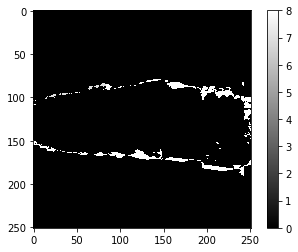

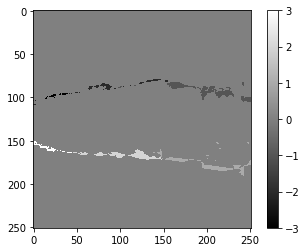

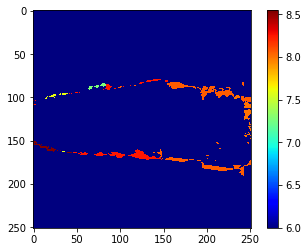

In [33]:
imx = gtx[0]
imy = gty[0]
ima = gta[0]

plt.imshow(imx, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(imy, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(ima, vmin=6, cmap='jet')
plt.colorbar()
plt.show()


In [41]:
ids = np.nonzero(gta)

diff_mean_amp = np.mean(np.abs(gta[ids] - va[ids]))
diff_std_amp = np.std(np.abs(gta[ids] - va[ids]))

In [43]:
print('Mean error:', diff_mean_amp)
print('Std of error:', diff_std_amp)

('Mean error:', 1.180505)
('Std of error:', 2.1500726)
